# Calculation of flame speed for the RMG detailed model model of n-decane without low temperature pathways

In [1]:
import sys
sys.path.append('/scratch/ajulu.c/anaconda3/envs/flame_env')

In [2]:
!which python
!conda list flame_env

/scratch/ajulu.c/anaconda3/envs/rmg_py3/bin/python
# packages in environment at /scratch/ajulu.c/anaconda3/envs/rmg_py3:
#
# Name                    Version                   Build  Channel


In [3]:
import cantera as ct
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import re
import scipy
import scipy.optimize

In [4]:
ct.__version__

'2.4.0'

In [5]:
model_name = 'chem'
fuel = 'nc10'

cantera_file_path = model_name+'.cti'
print(cantera_file_path)


chem.cti


In [6]:
# print(cantera_file_path)

# import os 
# assert os.path.exists('/scratch/ajulu.c/Code/GTL/nc10/nc10_lowT/no_lowT/chemkin/'+cantera_file_path)
gas = ct.Solution('/scratch/ajulu.c/Code/GTL/nc10/nc10_lowT/no_lowT/chemkin/'+cantera_file_path)



**** WARNING ****
For species HOCHO(59), discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -40.3604
	Value computed using high-temperature polynomial: -38.1678


In [7]:
sorted(gas.species_names)


['Ar',
 'C(32)',
 'C2(52)',
 'C2H(4)',
 'C2H2(33)',
 'C2H2O(730)',
 'C2H3(31)',
 'C2H3CO(84)',
 'C2H3O2(46)',
 'C2H3O2(68)',
 'C2H3O2(98)',
 'C2H3O3(60)',
 'C2H3O3(74)',
 'C2H3O3(75)',
 'C2H3O3(94)',
 'C2H3O3(97)',
 'C2H4(11)',
 'C2H4(752)',
 'C2H4O(42)',
 'C2H4O2(64)',
 'C2H4O2(96)',
 'C2H4O3(67)',
 'C2H4O4(93)',
 'C2H5(30)',
 'C2H5CO(86)',
 'C2H5O(38)',
 'C2H5O(43)',
 'C2H5O(55)',
 'C2H5O(88)',
 'C2H5O2(39)',
 'C2H5O2(45)',
 'C2H5O2(63)',
 'C2H5O2(95)',
 'C2H5O3(56)',
 'C2H5O3(89)',
 'C2H5O3(91)',
 'C2H5O5(92)',
 'C2H6(36)',
 'C2H6O(54)',
 'C2H6O(87)',
 'C2H6O2(62)',
 'C2H6O3(90)',
 'C2O(53)',
 'C3H3(77)',
 'C3H4(174)',
 'C3H4O(83)',
 'C3H5(103)',
 'C3H5(109)',
 'C3H5(110)',
 'C3H5O(137)',
 'C3H5O(140)',
 'C3H5O(175)',
 'C3H5O(79)',
 'C3H5O2(80)',
 'C3H5O3(81)',
 'C3H6(12)',
 'C3H6(753)',
 'C3H6O(125)',
 'C3H6O(126)',
 'C3H6O(78)',
 'C3H6O(85)',
 'C3H6O3(82)',
 'C3H7O(187)',
 'C3H7O(188)',
 'C3H8(100)',
 'C4H2(118)',
 'C4H3(116)',
 'C4H4(121)',
 'C4H5(114)',
 'C4H5(115)',
 'C4H5(117)

In [8]:
for species in gas.species():
    if species.composition == {'C':10, 'H':22}:
        print(species.name)

nC10H22(1)


In [9]:
species_names = {
    'nc10':'nC10H22(1)',
    'O2':'O2(2)',
    'N2':'N2',
    'CO':'CO(6)',
    'CO2':'CO2(7)',
    'CH4':'CH4(10)',
    'CH2O':'CH2O(9)',
    'C2H4':'C2H4(11)',
    'C2H6':'C2H6(36)',
    'C3H6':'C3H6(12)',
}

In [10]:
for s in species_names.values():
    assert s in gas.species_names , "{} not found".format(s)

In [11]:
print(len(gas.species()), len(gas.reactions()))

331 7381


In [12]:
def extrapolate_uncertainty(grids, speeds):
    """
    Given a list of grid sizes and a corresponding list of flame speeds,
    extrapolate and estimate the uncertainty in the final flame speed.
    Also makes a plot.
    """
    grids = list(grids)
    speeds = list(speeds)
    def speed_from_grid_size(grid_size, true_speed, error):
        """
        Given a grid size (or an array or list of grid sizes)
        return a prediction (or array of predictions)
        of the computed flame speed, based on 
        the parameters `true_speed` and `error`
        """
        return true_speed +  error * np.array(grid_size)**-1.

    popt, pcov = scipy.optimize.curve_fit(speed_from_grid_size, grids[-4:], speeds[-4:])#what does this mean

    perr = np.sqrt(np.diag(pcov))
    true_speed  = popt[0]
    percent_error_in_true_speed = 100.*perr[0] / popt[0]
    print("Fitted true_speed is {:.4f} ± {:.4f} cm/s ({:.1f}%)".format(
        popt[0]*100,
        perr[0]*100,
        percent_error_in_true_speed
        ))
    #print "convergerce rate wrt grid size is {:.1f} ± {:.1f}".format(popt[2], perr[2])
    estimated_percent_error = 100. * (speed_from_grid_size(grids[-1], *popt) - true_speed) / true_speed
    print("Estimated error in final calculation {:.1f}%".format(estimated_percent_error))

    total_error_estimate = abs(percent_error_in_true_speed) + abs(estimated_percent_error)
    print("Estimated total error {:.1f}%".format(total_error_estimate))

    plt.semilogx(grids,speeds,'o-')
    plt.ylim(min(speeds[-5:]+[true_speed-perr[0]])*.95, max(speeds[-5:]+[true_speed+perr[0]])*1.05)
    plt.plot(grids[-4:], speeds[-4:], 'or')
    extrapolated_grids = grids + [grids[-1] * i for i in range(2,8)]
    plt.plot(extrapolated_grids,speed_from_grid_size(extrapolated_grids,*popt),':r')
    plt.xlim(*plt.xlim())
    plt.hlines(true_speed, *plt.xlim(), colors=u'r', linestyles=u'dashed')

    plt.hlines(true_speed+perr[0], *plt.xlim(), colors=u'r', linestyles=u'dashed', alpha=0.3)
    plt.hlines(true_speed-perr[0], *plt.xlim(), colors=u'r', linestyles=u'dashed', alpha=0.3)
    plt.fill_between(plt.xlim(), true_speed-perr[0],true_speed+perr[0], facecolor='red', alpha=0.1 )

    #plt.text(grids[-1],speeds[-1],"{:.1f}%".format(estimated_percent_error))

    above = popt[1]/abs(popt[1]) # will be +1 if approach from above or -1 if approach from below
    
    plt.annotate("",
                xy=(grids[-1], true_speed),
                 xycoords='data',
                xytext=(grids[-1], speed_from_grid_size(grids[-1], *popt)),
                 textcoords='data',
                 arrowprops=dict(arrowstyle='|-|',
                                connectionstyle='arc3',
                                color='black', shrinkA=0, shrinkB=0),
                )
        
    plt.annotate("{:.1f}%".format(abs(estimated_percent_error)),
                xy=(grids[-1], speed_from_grid_size(grids[-1], *popt)),
                 xycoords='data',
                xytext=(10,20*above),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->',
                                connectionstyle='arc3')
                )
    
    plt.annotate("",
                xy=(grids[-1]*4, true_speed-(above*perr[0])),
                 xycoords='data',
                xytext=(grids[-1]*4, true_speed),
                 textcoords='data',
                 arrowprops=dict(arrowstyle='|-|',
                                connectionstyle='arc3',
                                color='black', shrinkA=0, shrinkB=0),
                )
    plt.annotate("{:.1f}%".format(abs(percent_error_in_true_speed)),
                xy=(grids[-1]*4, true_speed-(above*perr[0])),
                 xycoords='data',
                xytext=(10,-20*above),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->',
                                connectionstyle='arc3')
                )

    plt.ylabel("Flame speed (m/s)")
    plt.xlabel("Grid size")
    plt.show()
    
    return true_speed, total_error_estimate

In [13]:
def make_callback(flame):
    speeds = []
    grids = []

    def callback(_):
        speed = flame.u[0]
        grid = len(flame.grid)
        speeds.append(speed)
        grids.append(grid)
        print("Iteration {}".format(len(grids)))
        print("Current flame speed is is {:.4f} cm/s".format(speed*100.))
        if len(grids) < 5:
            return 1.0 # 
        try:
            extrapolate_uncertainty(grids, speeds)
        except Exception as e:
            print("Couldn't estimate uncertainty", e.message)
            return 1.0 # continue anyway

        return 1.0
    return callback, speeds, grids

T = 300 K
P = 101325.0 Pa

  gas:

       temperature             300  K
          pressure          101325  Pa
           density         1.20297  kg/m^3
  mean mol. weight         29.6137  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          -54826       -1.624e+06     J
   internal energy     -1.3906e+05       -4.118e+06     J
           entropy          6803.9        2.015e+05     J/K
    Gibbs function      -2.096e+06       -6.207e+07     J
 heat capacity c_p          1030.8        3.053e+04     J/K
 heat capacity c_v          750.06        2.221e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.784684         0.742284         -23.2749
        nC10H22(1)     0.00672861         0.032329         -171.015
             O2(2)       0.208587         0.225387         -26.2252
  


..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [51] point grid(s).
Iteration 4
Current flame speed is is 6.0164 cm/s

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 4 9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 46 48 
    to resolve C2H2(33) C2H3(31) C2H4(11) C2H4(752) C2H4O(42) C2H5(30) C2H5O(43) C2H5O2(39) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H4(121) C4H5(115) C4H5(117) C4H6(202) C4H7(198) C4H8O(222) C5H11(426) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(762) C6H6(112) C6H6(113) C8H17(685) CC

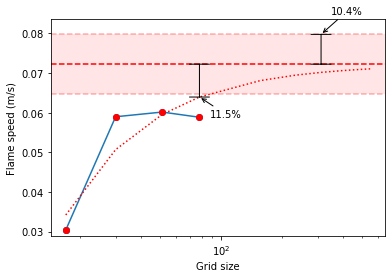


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 3 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 76 
    to resolve C2H2(33) C2H3(31) C2H4(11) C2H4(752) C2H4O(42) C2H5(30) C2H5O(43) C2H5O2(39) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H8(100) C4H2(118) C4H4(121) C4H5(115) C4H5(117) C4H6(202) C4H7(198) C4H8O(222) C5H11(426) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(762) C6H6(112) C6H6(113) CC3H6(108) CH2(22) CH2CHO(40) CH2CO(29) CH2O(9) CH2OH(25) CH3(21) CH3CHO(37) CH3O(26) CH3OH(23) CH3OO(28) CH3OOH(34) CH4(10) CO(6) CO2(7) H(14) H2(13) H2O(8) H2O2(18) HCCO(49) HCCOH(50) HCO(20) HO2(17) HO2CHO(70) HOCHO(59) IC3H7(10

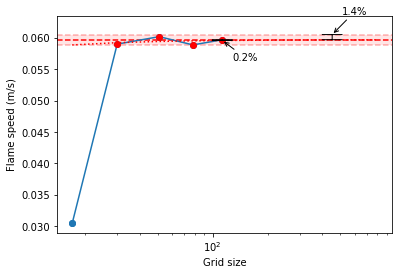


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 2 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 87 
    to resolve C2H2(33) C2H3(31) C2H4(11) C2H4(752) C2H4O(42) C2H5(30) C2H5O2(39) C2H6(36) C2H6O(54) C2H6O2(62) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H8(100) C4H2(118) C4H4(121) C4H6(202) C4H7(198) C4H8O(222) C5H6(119) C6H10(347) C6H12(755) C6H6(112) C6H6(113) CC3H6(108) CH2(22) CH2CHO(40) CH2CO(29) CH2O(9) CH2OH(25) CH3(21) CH3CHO(37) CH3OH(23) CH3OO(28) CH3OOH(34) CH4(10) CO(6) CO2(7) H(14) H2(13) H2O(8) H2O2(18) HCCO(49) HCCOH(50) HCO(20) HO2(17) HO2CHO(70) HOCHO(59) IC3H7(102) N2 NC3H7(101) O(5) O2(2) O2CHO(69) O

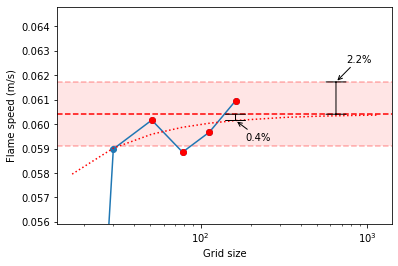


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 32 42 43 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 111 112 113 114 
    to resolve C2H2(33) C2H3(31) C2H4(11) C2H4(752) C2H4O(42) C2H5(30) C2H5O2(39) C2H6(36) C2H6O(54) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H8(100) C4H2(118) C4H4(121) C4H6(202) C4H7(198) C4H8O(222) C5H6(119) C6H10(347) C6H12(755) C6H6(113) CC3H6(108) CH2(22) CH2CHO(40) CH2CO(29) CH2O(9) CH2OH(25) CH3(21) CH3CHO(37) CH3OH(23) CH3OO(28) CH3OOH(34) CH4(10) CO(6) H(14) H2(13) H2O(8) H2O2(18) HCCO(49) HCCOH(50) HCO(20) HO2(17) HOCHO(59) IC3H7(102) N2 NC3H7(101) O(5) O2(2) O2CHO(69) 

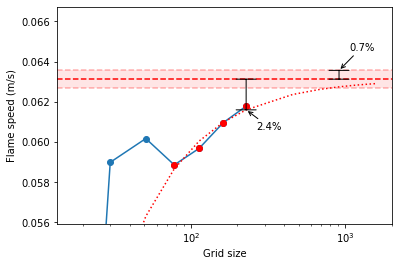


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 42 57 58 59 60 61 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 167 
    to resolve C2H2(33) C2H3(31) C2H4(11) C2H4(752) C2H4O(42) C2H5(30) C2H6(36) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H6(12) C3H6O(78) C3H6O(85) C3H8(100) C4H4(121) C4H6(202) C4H7(198) C4H8O(222) C6H10(347) C6H12(755) CH2CHO(40) CH2CO(29) CH2O(9) CH3(21) CH3OH(23) CH3OO(28) CH4(10) CO(6) H2(13) HCCO(49) HCO(20) HO2(17) IC3H7(102) N2 NC3H7(101) O(5) OCHCHO(48) OH(15) PC4H9(190) S(1013) S(1046) S(1058) S(1211) S(14523) S(192) S(8316) S(9013) SC4H9(191) nC10H22(1) point 167 
#################################################

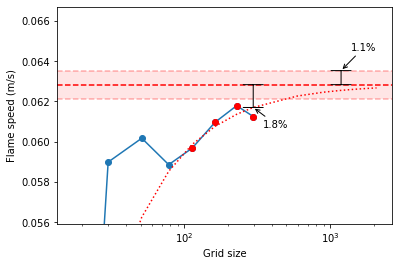


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 41 
    to resolve point 41 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [297] point grid(s).
Iteration 10
Current flame speed is is 6.1220 cm/s
Fitted true_speed is 6.1694 ± 0.0776 cm/s (1.3%)
Estimated error in final calculation -0.5%
Estimated total error 1.8%


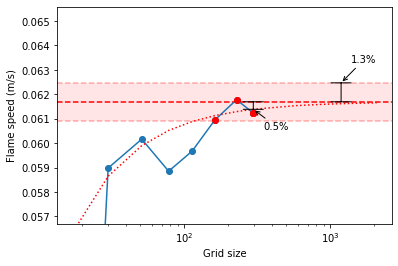


..............................................................................
no new points needed in flame
Fitted true_speed is 6.1694 ± 0.0776 cm/s (1.3%)
Estimated error in final calculation -0.5%
Estimated total error 1.8%


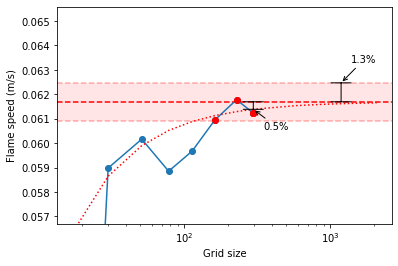


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         1.22595  kg/m^3
  mean mol. weight         30.1794  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          -95106        -2.87e+06     J
   internal energy     -1.7776e+05       -5.365e+06     J
           entropy          6740.4        2.034e+05     J/K
    Gibbs function     -2.1172e+06        -6.39e+07     J
 heat capacity c_p          1045.5        3.155e+04     J/K
 heat capacity c_v          769.97        2.324e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.780744         0.724712         -23.2799
        nC10H22(1)      0.0117159        0.0552364         -170.461
             O2(2)        0.20754         0.220052         -26.2302
     [ +328 minor]          


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     7.119e-06       5.66
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0002737      4.768
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.435e-05      6.472
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0002774      5.174
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.000395      5.337
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps         0.002      3.314
Attempt Newton solution of steady-state problem...    success.

Problem solved on [32] point grid(s).
Iteration 3
Current flame speed is is 45.1757 cm/s

..............................................................................
#############################################

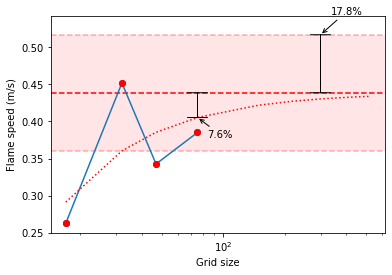


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H3O2(46) C2H3O3(60) C2H3O3(74) C2H4(11) C2H4(752) C2H4O(42) C2H4O2(64) C2H4O2(96) C2H4O3(67) C2H5(30) C2H5O(38) C2H5O(43) C2H5O(55) C2H5O2(39) C2H5O3(56) C2H5O3(89) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(137) C3H5O(140) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H3(116) C4H4(121) C4H5(114) C4H5(115) C4H5(117) C4H6(202) C4H6(3155) C4H7(198) C4H8O(222) C5H11(426) C5H11(427) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C6H5(111) C6H6(112) C6H6(113) C7H15(684) C8H17(685) CC3H6(108) CH

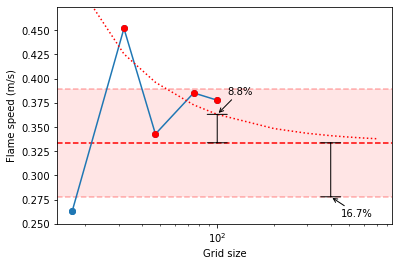


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 59 60 84 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H3O2(46) C2H3O3(60) C2H3O3(74) C2H4(11) C2H4(752) C2H4O(42) C2H4O2(96) C2H4O3(67) C2H5(30) C2H5O(38) C2H5O(43) C2H5O(55) C2H5O2(39) C2H5O3(56) C2H5O3(89) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(137) C3H5O(140) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H3(116) C4H4(121) C4H5(114) C4H5(115) C4H5(117) C4H6(202) C4H6(3155) C4H7(198) C4H7O(276) C4H8O(222) C5H11(426) C5H11(427) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C6H5(111) C6H6(112) C6H6(113) C7H15(684) C8H17(685) CC3H6(108) CH

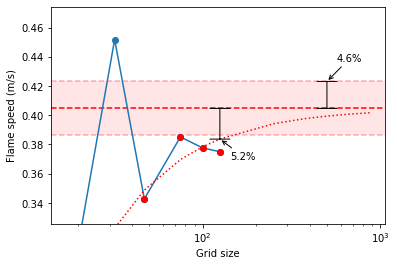


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 19 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 64 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H3O3(60) C2H3O3(74) C2H4(11) C2H4(752) C2H4O(42) C2H4O2(96) C2H4O3(67) C2H5(30) C2H5O(38) C2H5O(43) C2H5O(55) C2H5O2(39) C2H5O3(56) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H3(116) C4H4(121) C4H5(114) C4H5(115) C4H5(117) C4H6(202) C4H6(3155) C4H7(198) C4H7O(276) C4H8O(222) C5H11(426) C5H11(427) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C6H5(111) C6H6(112) C6H6(113) C7H15(684) C8H17(685) CC3H6(108) CH(3) CH2(22) CH2(S)(24) CH2CHO

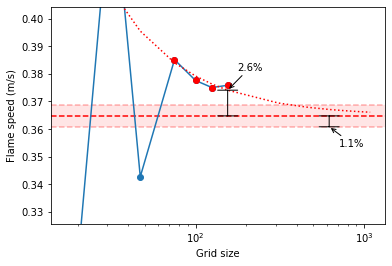


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 
    to resolve C(32) C2H2(33) C2H3(31) C2H3O3(60) C2H3O3(74) C2H4(11) C2H4(752) C2H4O(42) C2H4O3(67) C2H5(30) C2H5O(43) C2H5O(55) C2H5O2(39) C2H5O3(56) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H3(116) C4H4(121) C4H5(114) C4H5(115) C4H5(117) C4H6(202) C4H6(3155) C4H7(198) C4H8O(222) C5H11(426) C5H11(427) C5H6(119) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C6H6(112) C6H6(113) C7H15(684) C8H17(685) CC3H6(108) CH(3) CH2(22) CH2(S)(24) CH2CHO(40) CH2CO(29) CH2O(9) CH2

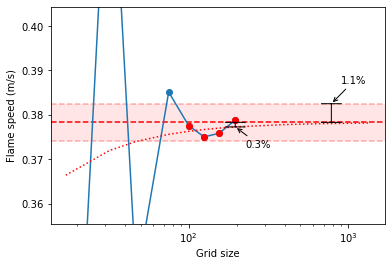


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 31 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 
    to resolve C2H2(33) C2H3(31) C2H3O3(60) C2H3O3(74) C2H4(11) C2H4(752) C2H4O(42) C2H5(30) C2H5O(43) C2H5O(55) C2H5O2(39) C2H5O3(56) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H4(121) C4H5(114) C4H5(115) C4H5(117) C4H6(202) C4H7(198) C4H8O(222) C5H11(426) C5H11(427) C5H6(119) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C7H15(684) C8H17(685) CC3H6(108) CH(3) CH2(22) CH2CHO(40) CH2CO(29) CH2O(9) CH2OH(25) C

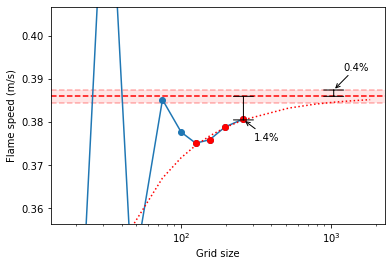


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 
    to resolve C2H2(33) C2H3(31) C2H4(752) C2H5(30) C2H5O(43) C2H5O2(39) C2H5O3(56) C2H6(36) C2H6O2(62) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H8(100) C4H4(121) C4H6(202) C4H7(198) C4H8O(222) C5H11(426) C5H11(427) C6H12(755) C6H13(687) C6H13(762) C7H15(684) C8H17(685) CH3(21) CH3CHO(37) CH3O(26) CH3OO(28) CH3OOH(34) HCCO(49) HCO(20) HO2CHO(70) IC3H7(102) NC3H7(101) PC4H9(190) S(1013) S(1039) S(104) S(1043) S(1046) S(105) S(1

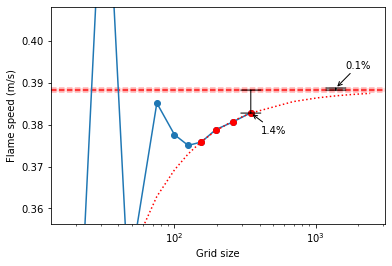


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 
    to resolve C4H8O(222) C7H15(684) C8H17(685) PC4H9(190) S(1013) S(1058) S(1311) S(1315) S(1349) S(1406) S(192) S(6208) S(689) S(691) 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [387] point grid(s).
Iteration 12
Current flame speed is is 38.3422 cm/s
Fitted true_speed is 38.8108 ± 0.0491 cm/s (0.1%)
Estimated error in final calculation -1.2%
Estimated total error 1.4%


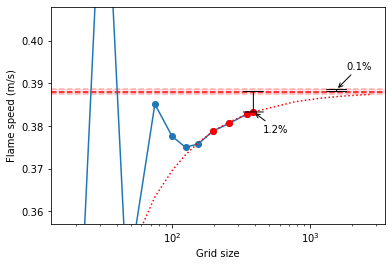


..............................................................................
no new points needed in flame
Fitted true_speed is 38.8108 ± 0.0491 cm/s (0.1%)
Estimated error in final calculation -1.2%
Estimated total error 1.4%


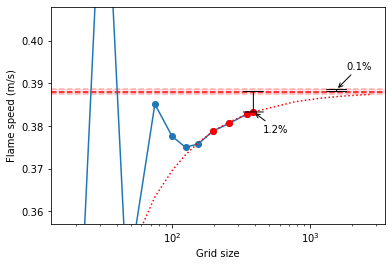


  gas:

       temperature             300  K
          pressure          101325  Pa
           density          1.2487  kg/m^3
  mean mol. weight         30.7395  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -1.3352e+05       -4.104e+06     J
   internal energy     -2.1467e+05       -6.599e+06     J
           entropy          6679.2        2.053e+05     J/K
    Gibbs function     -2.1373e+06        -6.57e+07     J
 heat capacity c_p          1059.4        3.257e+04     J/K
 heat capacity c_v          788.97        2.425e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.776844         0.707953         -23.2849
        nC10H22(1)      0.0166534        0.0770843         -170.109
             O2(2)       0.206503         0.214963         -26.2352
     [ +328 minor]          


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      3.56e-06      5.744
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      1.52e-05      6.191
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      8.66e-05      5.177
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0009864       5.46
Attempt Newton solution of steady-state problem...    success.

Problem solved on [28] point grid(s).
Iteration 3
Current flame speed is is 68.7779 cm/s

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 5 6 7 8 9 10 11 12 13 14 15 16 17 22 23 24 25 26 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H3CO(84) C2H3O2(

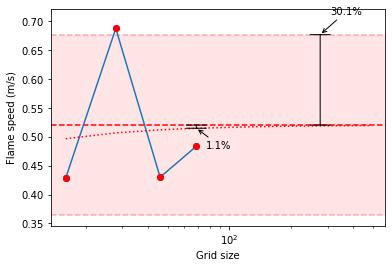


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 37 38 67 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H3O2(46) C2H3O3(60) C2H3O3(74) C2H4(11) C2H4(752) C2H4O(42) C2H4O2(64) C2H4O2(96) C2H4O3(67) C2H5(30) C2H5O(38) C2H5O(43) C2H5O(55) C2H5O(88) C2H5O2(39) C2H5O3(56) C2H5O3(89) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2H6O3(90) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(137) C3H5O(140) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6(753) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H3(116) C4H4(121) C4H5(114) C4H5(115) C4H5(117) C4H6(202) C4H6(3155) C4H7(198) C4H7O(276) C4H8O(222) C5H11(426) C5H11(427) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C6H5(111) C6H6(112) C6H6(1

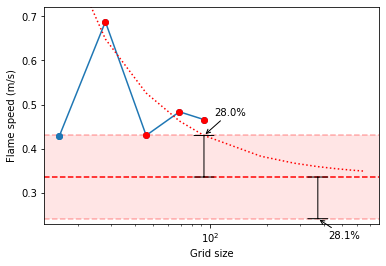


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H3O2(46) C2H3O3(60) C2H3O3(74) C2H4(11) C2H4(752) C2H4O(42) C2H4O2(64) C2H4O2(96) C2H4O3(67) C2H5(30) C2H5O(38) C2H5O(43) C2H5O(55) C2H5O2(39) C2H5O3(56) C2H5O3(89) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(137) C3H5O(140) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6(753) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H3(116) C4H4(121) C4H5(114) C4H5(115) C4H5(117) C4H6(202) C4H6(3155) C4H7(198) C4H7O(276) C4H8O(222) C5H11(426) C5H11(427) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C6H5(111) C6H6(112) C6H6(113) C7H15(684) C8H17(685) CC3H6(1

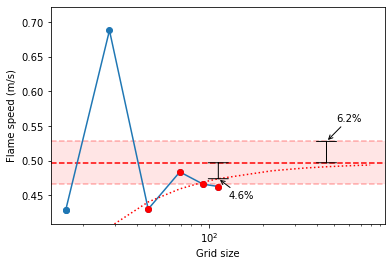


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 19 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 60 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H3O2(46) C2H3O3(60) C2H3O3(74) C2H4(11) C2H4(752) C2H4O(42) C2H4O2(96) C2H4O3(67) C2H5(30) C2H5O(38) C2H5O(43) C2H5O(55) C2H5O2(39) C2H5O3(56) C2H5O3(89) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(137) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6(753) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H3(116) C4H4(121) C4H5(114) C4H5(115) C4H5(117) C4H6(202) C4H6(3155) C4H7(198) C4H7O(276) C4H8O(222) C5H11(426) C5H11(427) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C6H5(111) C6H6(112) C6H6(113) C7H15(684) C8H17(685)

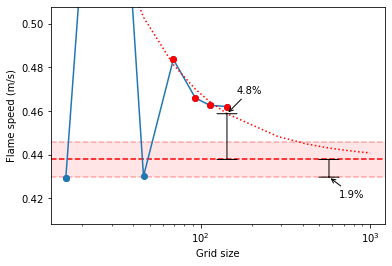


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H3O2(46) C2H3O3(60) C2H3O3(74) C2H4(11) C2H4(752) C2H4O(42) C2H4O2(96) C2H4O3(67) C2H5(30) C2H5O(38) C2H5O(43) C2H5O(55) C2H5O2(39) C2H5O3(56) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H3(116) C4H4(121) C4H5(114) C4H5(115) C4H5(117) C4H6(202) C4H6(3155) C4H7(198) C4H7O(276) C4H8O(222) C5H11(426) C5H11(427) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C6H5(111) C6H6(112) C6H6(113) C7H15(684) C8H17(685) C

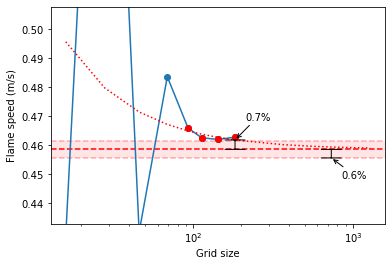


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H3O3(60) C2H3O3(74) C2H4(11) C2H4(752) C2H4O(42) C2H5(30) C2H5O(43) C2H5O(55) C2H5O2(39) C2H5O3(56) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H3(116) C4H4(121) C4H5(114) C4H5(115) C4H5(117) C4H6(202) C4H6(3155) C4H7(198) C4H8O(222) C5H11(426) C5H11(427) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C6H6(112) C6H6(113) C7H15(684) C8H17(6

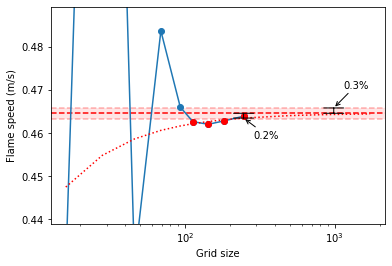


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 
    to resolve C2H2(33) C2H3(31) C2H3O3(60) C2H4(11) C2H4O(42) C2H5(30) C2H5O(43) C2H5O2(39) C2H5O3(56) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H8(100) C4H4(121) C4H6(202) C4H7(198) C4H8O(222) C5H11(426) C5H11(427) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C7H15(684) C8H17(685) CC3H6(108) CH2(22) CH2CHO(40) CH2CO(29) CH2O(9) C

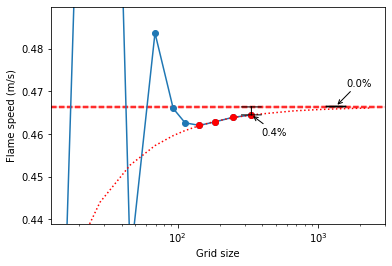


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 70 71 72 73 74 75 82 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 183 184 185 
    to resolve C2H5O2(39) C4H6(202) C4H8O(222) C5H11(426) C5H11(427) C6H13(762) C7H15(684) C8H17(685) CH3OO(28) PC4H9(190) S(1013) S(1039) S(104) S(105) S(1058) S(106) S(1083) S(1169) S(1211) S(1306) S(1311) S(1315) S(1349) S(1406) S(14485) S(14523) S(192) S(1920) S(260) S(30358) S(3501) S(441) S(443) S(6204) S(6208) S(689) S(691) S(692) S(862) 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [383] point 

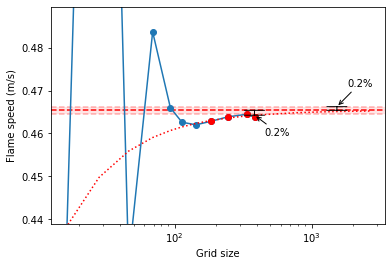


..............................................................................
no new points needed in flame
Fitted true_speed is 46.5395 ± 0.0848 cm/s (0.2%)
Estimated error in final calculation -0.2%
Estimated total error 0.4%


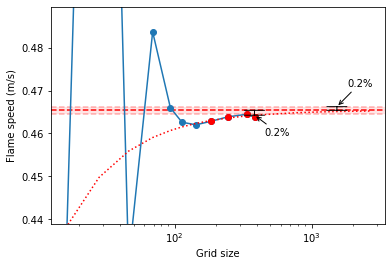


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         1.27122  kg/m^3
  mean mol. weight          31.294  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      -1.702e+05       -5.326e+06     J
   internal energy     -2.4991e+05       -7.821e+06     J
           entropy          6620.4        2.072e+05     J/K
    Gibbs function     -2.1563e+06       -6.748e+07     J
 heat capacity c_p          1072.8        3.357e+04     J/K
 heat capacity c_v           807.1        2.526e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.772982         0.691951         -23.2899
        nC10H22(1)      0.0215419        0.0979446         -169.852
             O2(2)       0.205476         0.210104         -26.2402
     [ +328 minor]          


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0002563      4.969
Attempt Newton solution of steady-state problem...    success.

Problem solved on [44] point grid(s).
Iteration 4
Current flame speed is is 12.0831 cm/s

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H3O3(60) C2H4(11) C2H4(752) C2H4O(42) C2H4O3(67) C2H5(30) C2H5O(43) C2H5O2(39) C2H5O3(56) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H3(116)

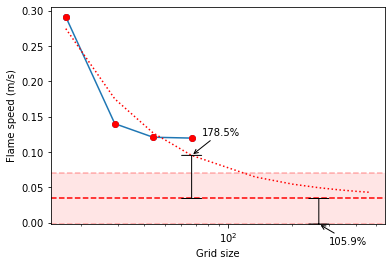


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 10 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H3O3(60) C2H4(11) C2H4(752) C2H4O(42) C2H5(30) C2H5O(43) C2H5O2(39) C2H5O3(56) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H6O3(82) C3H8(100) C4H2(118) C4H3(116) C4H4(121) C4H5(114) C4H5(115) C4H5(117) C4H6(202) C4H6(3155) C4H7(198) C4H8O(222) C5H11(426) C5H11(427) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C6H5(111) C6H6(112) C6H6(113) C7H15(684) C8H17(685) CC3H6(108) CH(3) CH2(22) CH2(S)(24) CH2CHO(40) CH2CO(29) CH2O(9) CH2OH(25) CH3(21) CH3CHO(37) CH3O(26) CH3

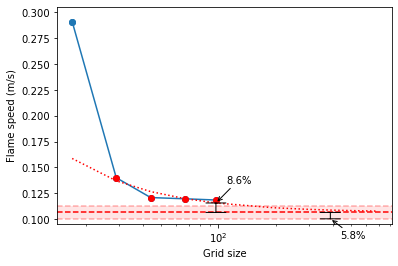


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H4(11) C2H4(752) C2H4O(42) C2H5(30) C2H5O2(39) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H8(100) C4H2(118) C4H3(116) C4H4(121) C4H5(114) C4H5(115) C4H5(117) C4H6(202) C4H6(3155) C4H7(198) C4H8O(222) C5H11(426) C5H11(427) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(687) C6H13(762) C6H5(111) C6H6(112) C6H6(113) C7H15(684) C8H17(685) CC3H6(108) CH(3) CH2(22) CH2(S)(24) CH2CHO(40) CH2CO(29) CH2O(9) CH2OH(25) CH3(21) CH3CHO(37) CH3O(26) CH3OH(23) CH3OO(28) CH3OOH(34) CH4

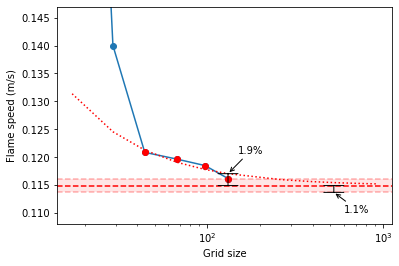


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 103 
    to resolve C(32) C2H(4) C2H2(33) C2H3(31) C2H4(11) C2H4(752) C2H4O(42) C2H5(30) C2H5O2(39) C2H6(36) C2H6O(54) C2H6O(87) C2H6O2(62) C2O(53) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H5O(175) C3H5O(79) C3H5O3(81) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H8(100) C4H2(118) C4H4(121) C4H5(115) C4H5(117) C4H6(202) C4H6(3155) C4H7(198) C4H8O(222) C5H11(426) C5H11(427) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H13(762) C6H5(111) C6H6(112) C6H6(113) C7H15(684) CC3H6(108) CH(3) CH2(22) CH2(S)(24) CH2CHO(40) CH2CO(29) CH2O(9) CH2OH(25) CH3(21) CH3CHO(37) CH3O(26) CH3OH(23) CH

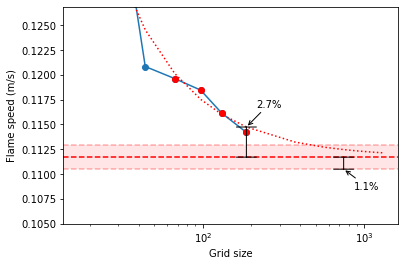


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 142 
    to resolve C2H2(33) C2H3(31) C2H4(11) C2H4(752) C2H4O(42) C2H5(30) C2H5O2(39) C2H6(36) C2H6O2(62) C3H3(77) C3H4(174) C3H4O(83) C3H5(103) C3H5(109) C3H5(110) C3H6(12) C3H6O(125) C3H6O(126) C3H6O(78) C3H6O(85) C3H8(100) C4H2(118) C4H4(121) C4H6(202) C4H7(198) C4H8O(222) C5H11(426) C5H5(120) C5H6(119) C6H10(347) C6H12(755) C6H5(111) C6H6(112) C6H6(113) CC3H6(108) CH2(22) CH2CHO(40) CH2CO(29) CH2O(9) CH3(21) CH3OH(23) CH3OO(28) CH3OOH(34) CH4(10) H(14) H2CC(76) H2O2(18) HCCO(49) HCO(20) HO2(17) IC3H

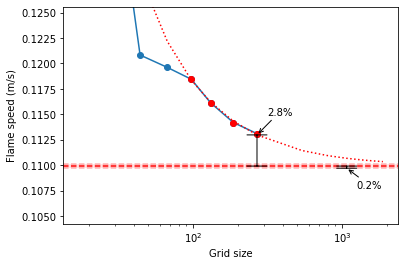


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 68 69 70 71 72 73 74 75 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 141 142 143 144 145 146 147 148 149 150 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 225 
    to resolve C3H5(103) C3H5(109) C3H6(12) C4H6(202) C4H7(198) C4H8O(222) C6H12(755) CH3(21) CH3OO(28) IC3H7(102) NC3H7(101) PC4H9(190) S(1013) S(1043) S(1046) S(1058) S(1083) S(1211) S(1349) S(14523) S(192) S(8316) SC4H9(191) nC10H22(1) point 225 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [334] point grid(s).
Iteration 10
Current

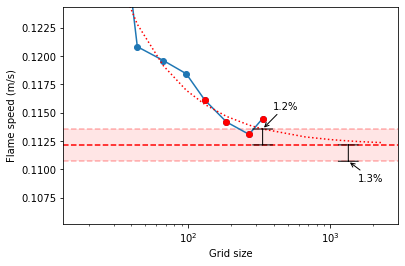


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 93 195 196 
    to resolve S(1046) point 93 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [337] point grid(s).
Iteration 11
Current flame speed is is 11.4594 cm/s
Fitted true_speed is 11.4605 ± 0.1629 cm/s (1.4%)
Estimated error in final calculation -0.3%
Estimated total error 1.8%


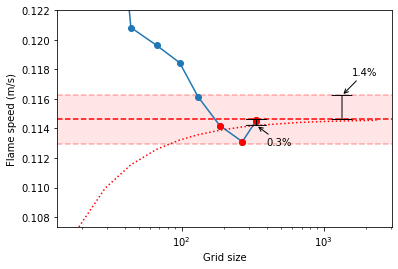


..............................................................................
no new points needed in flame
Fitted true_speed is 11.4605 ± 0.1629 cm/s (1.4%)
Estimated error in final calculation -0.3%
Estimated total error 1.8%


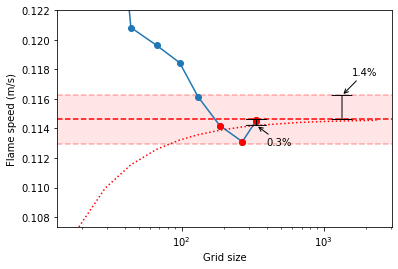


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         1.29353  kg/m^3
  mean mol. weight          31.843  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -2.0526e+05       -6.536e+06     J
   internal energy     -2.8359e+05        -9.03e+06     J
           entropy          6563.9         2.09e+05     J/K
    Gibbs function     -2.1744e+06       -6.924e+07     J
 heat capacity c_p          1085.5        3.457e+04     J/K
 heat capacity c_v          824.44        2.625e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.769158         0.676657         -23.2949
        nC10H22(1)      0.0263819         0.117883         -169.649
             O2(2)        0.20446          0.20546         -26.2452
     [ +328 minor]          


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps   

In [ ]:
phis = np.linspace(0.5,2.0,5)
#phi = 1.0
temperature = 300 # K
pressures = np.multiply([1,2,6,10], ct.one_atm)# pressure in atm
# pressure = np.multiply(1, ct.one_atm)

results = dict()


for P in pressures:
    
    P_flame = []
    print("T = {} K".format(temperature))
    print("P = {} Pa".format(P))
    
    for phi in phis: #For a given phi value calculate the mole fractions
        
        gas.set_equivalence_ratio(phi=phi, fuel=species_names['nc10'], oxidizer={
            species_names['O2']:0.21,
            species_names['N2']:0.79})
        gas.mole_fraction_dict()
        gas.TP = (temperature,P)
        gas()


        width = 0.015 #m

        # Create the flame object
        flame = ct.FreeFlame(gas, width=width)

        # Define tolerances for the solver
        # (these are used throughout the notebook)
        # refine_criteria = {'ratio':3, 'slope': 0.1, 'curve': 0.1}   # less accurate
        refine_criteria = {'ratio':2, 'slope': 0.05, 'curve': 0.05}  # more accurate
        flame.set_refine_criteria(**refine_criteria)

        try:
            flame.set_max_grid_points(flame.domains[flame.domain_index('flame')], 1e4)
        except AttributeError:
            "this feature was added to Cantera in 2.3.0b1"
            #https://github.com/Cantera/cantera/commit/a82dd5a4836b75ea91eb0fb58ec74bea164cbd9f
        pass

        callback, speeds, grids = make_callback(flame)
        flame.set_steady_callback(callback)

        # Define logging level
        loglevel = 1

        flame.solve(loglevel=loglevel, auto=True)

        true_speed, total_error_estimate = extrapolate_uncertainty(grids, speeds)

        P_flame.append((true_speed, total_error_estimate))

        results[P] = P_flame

#Use the adjoint method to calculate the sensitivities
# sens = flame.get_flame_speed_reaction_sensitivities()

# print()
# print('Rxn #  k/S*dS/dk    Reaction Equation')
# print('-----   ----------    ------------------------')

# for m in range(gas.n_reactions):
#     print('{: 5d}  {: 10.3e}  {}'.format(m, sens[m], gas.reaction_equation(m)))


In [ ]:
# def plot_profiles(flame):
#     for name in 'nC10 CO CO2 O2'.split():
#         index = gas.species_index(name)
#         plt.plot(flame.grid*100, flame.X[index], label=name)
#     plt.legend()
#     plt.xlabel('distance (cm)')
#     plt.ylabel('mole fraction')
#     plt.show()

#     for name in 'CH4 C2H4 C2H6 C3H6 CH2O'.split():
#         index = gas.species_index(name)
#         plt.plot(flame.grid*100, flame.X[index], label=name)
#     plt.legend()
#     plt.xlabel('distance (cm)')
#     plt.ylabel('mole fraction')
#     plt.show()
    
#     plt.plot(flame.grid*100, flame.T)
#     plt.xlabel('distance (cm)')
#     plt.ylabel('temperature (K)')
#     plt.ylim(bottom=0)
#     plt.show()

In [ ]:
# def callback(_):
#     plot_profiles(flame)
#     return 1.0
# flame.set_steady_callback(callback)

AssertionError: 

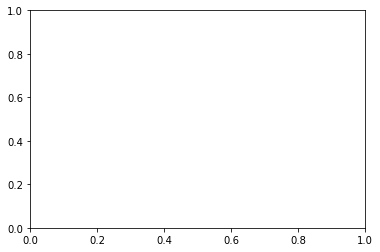

In [30]:
for pressure in sorted(results.keys()):
    P_flame = results[pressure]
    if len(P_flame) < len(phis):
        continue # because this pressure run is incomplete
    speeds = [100*result[0] for result in P_flame] # speed in cm/s
    errors = [100*result[0]*result[1]/100. for result in P_flame] # error in cm/s
plt.errorbar(phis, speeds, yerr=errors, label='{} atm'.format(pressure/ct.one_atm))
plt.legend(loc='best')
plt.xlabel('Equivalence ratio $\phi$')
plt.ylabel('Flame Speed (cm/s)')
plt.show()